## Week 7 — Adaptive Schedule Generator (Summary)

This notebook generates an **optimized staff schedule for week 7**, based on real demand
from weeks 4–6 (transaction data).

### Process Overview

1. **Demand Aggregation**
   - Loads `transactions_4.json` to `transactions_6.json`
   - Calculates total merchandise units sold per weekday
   - Determines weakest days relative to the **median demand**

2. **Adaptive Reduction**
   - Up to 5 lowest-demand days are selected
   - Reduction amount per day depends on demand drop:
     | Demand vs. Median | Removed Workers |
     |------------------|-----------------|
     | < 70%            | 5               |
     | < 90%            | 4               |
     | < 100%           | 2               |
     | ≥ Median         | 0               |

3. **Balanced Staff Removal Strategy**
   - Removes workers in this priority order:
     1. Shift 2 – registers
     2. Shift 2 – utilities
     3. Shift 1 – registers
     4. Shift 1 – utilities
   - Within each bucket, workers with **highest salary are removed first**
   - Never reduces a day below **10 total staff**

4. **Output**
   - Writes the new schedule to:  
     `data/schedules/schedules_7.json`
   - Writes audit logs:
     - `schedules_removed_adaptive.csv` — who was removed
     - `schedules_staff_cmp_adaptive.csv` — before/after staff comparison

### Result

This approach ensures:
- fewer payroll costs on weak-sales days,
- stability and minimum staffing guarantees,
- transparent reduction decisions (audit logs).

Loaded data/transactions/transactions_4.json
Loaded data/transactions/transactions_5.json
Loaded data/transactions/transactions_6.json

== Demand by Day (Weeks 4-6) ==
 day  demand_score   share_%      cum_%
   1          6541  7.058227   7.058227
   2         13486 14.552400  21.610627
   3         14170 15.290487  36.901114
   4         16103 17.376338  54.277452
   5         22068 23.813018  78.090470
   6         15231 16.435385  94.525855
   7          5073  5.474145 100.000000


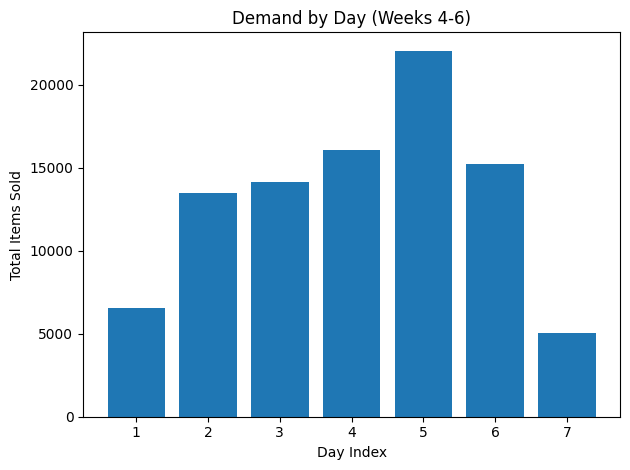

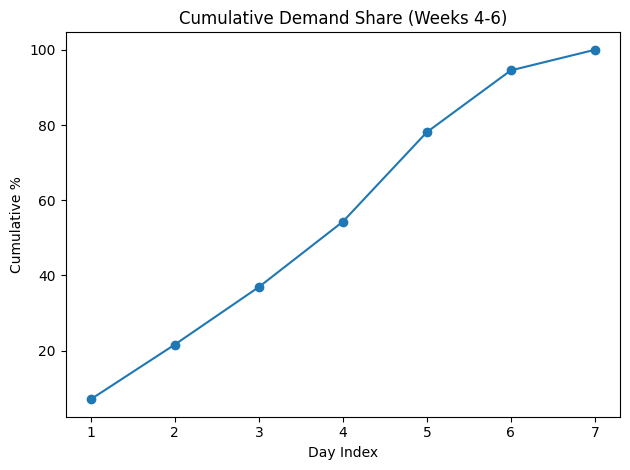


== Adaptive low-day plan ==
 day  demand_score   share_%      cum_%  k_remove
   7          5073  5.474145 100.000000         5
   1          6541  7.058227   7.058227         5
   2         13486 14.552400  21.610627         2
   3         14170 15.290487  36.901114         0
   6         15231 16.435385  94.525855         0

== Removed workers (adaptive) ==
    day                              worker_id  shift department      salary  k_target  k_effective
 monday w_ec6c9075-3922-42a9-9f50-012d91ea9163      2  registers 7180.282748         5            5
 monday w_0f1b727e-b833-4be8-9199-5f00f1dde500      2  registers 6750.245863         5            5
 monday w_f468bcd4-88ee-4b55-afaf-a1de2fe9503e      2  utilities 7848.449549         5            5
 monday w_f1d7e62a-8d54-40d3-a775-729fd40642e2      2  utilities 7748.436987         5            5
 monday w_aa04f664-fb82-4343-be47-803507429374      1  registers 7128.900910         5            5
tuesday w_ec6c9075-3922-42a9-9f50-012

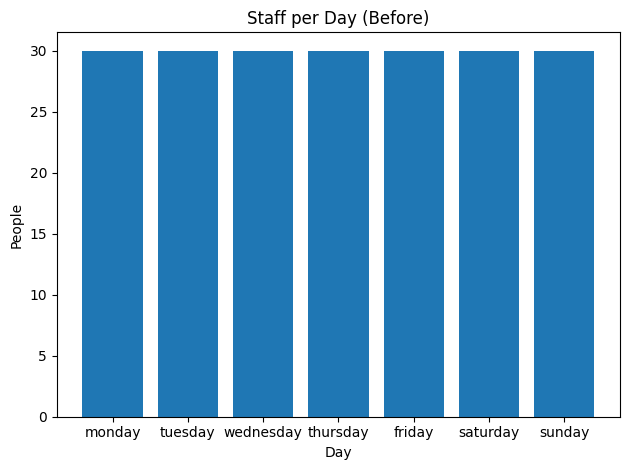

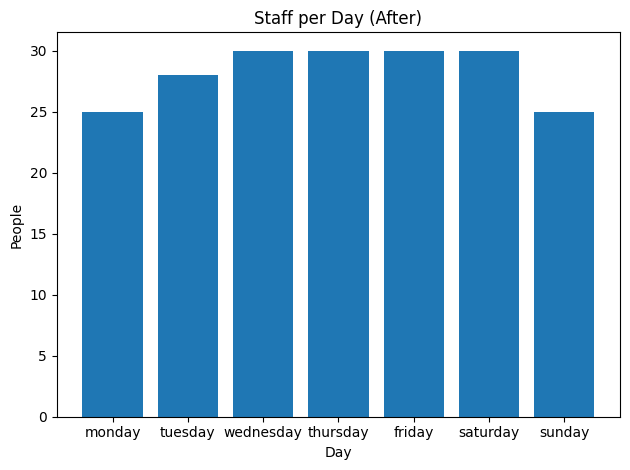


Saved schedules: data/schedules/schedules_7.json
Audit (removed): data/schedules/schedules_removed_adaptive.csv
Audit (staff cmp): data/schedules/schedules_staff_cmp_adaptive.csv


In [10]:
# ================================================================ 
# Schedule Generator — Week 7 (Adaptive, Demand-Aware) 
# ================================================================ 
# Goal:
# - Analyze demand from the last 3 weeks (transactions_4–6.json)
# - Determine the weakest days adaptively relative to the median
# - Reduce staffing there (highest salary first; preference: shift2->registers,
#   shift2->utilities, shift1->registers, shift1->utilities)
# - Write new schedules_7.json to "data/schedules/"
#
# Notes:
# - No external packages except pandas/matplotlib.
# - Paths primarily under ./data/... ; fallback to /mnt/data if local not available.
# - Visualizations with matplotlib (kept simple).
# ================================================================

import json
from pathlib import Path
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------- Paths / IO -------------------------------
# Primary structure (as specified)
DATA_DIR = Path("data")
TX_DIR = DATA_DIR / "transactions"
WK_DIR = DATA_DIR / "workers"
SC_DIR = DATA_DIR / "schedules"

# Fallback directory (e.g., available in this chat session)
FALLBACK = Path("/mnt/data")

# Inputs
TX_WEEKS = [4, 5, 6]
TX_PATHS = [(TX_DIR / f"transactions_{w}.json", FALLBACK / f"transactions_{w}.json") for w in TX_WEEKS]
WORKERS_PATHS = (WK_DIR / "workers.jsonl", FALLBACK / "workers.jsonl")
SCHEDULE6_PATHS = (SC_DIR / "schedules_6.json", FALLBACK / "schedules_6.json")

# Output
SC_DIR.mkdir(parents=True, exist_ok=True)
OUT_SCHEDULE7 = SC_DIR / "schedules_7.json"

# Backup output additionally in /mnt/data (optional)
OUT_SCHEDULE7_FALLBACK = FALLBACK / "schedules_7.json"

# Audit files
OUT_AUDIT_REMOVED = SC_DIR / "schedules_removed_adaptive.csv"
OUT_AUDIT_STAFF = SC_DIR / "schedules_staff_cmp_adaptive.csv"


# ------------------------------- Helper -----------------------------------
def first_existing(*paths: Path) -> Path | None:
    """Gibt den ersten existierenden Pfad zurück, sonst None."""
    for p in paths:
        if p and Path(p).exists():
            return Path(p)
    return None

def load_json(path: Path) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def safe_int(x, default=0):
    try:
        return int(x)
    except:
        return default


# ------------------------- 1) Aggregate demand ----------------------------
def aggregate_demand():
    tx_loaded = {}
    for local, fb in TX_PATHS:
        p = first_existing(local, fb)
        if p is None:
            print(f"Missing transactions file for: {local.name}")
            continue
        try:
            tx_loaded[p.name] = load_json(p)
            print(f"Loaded {p}")
        except Exception as e:
            print(f"Error loading {p}: {e}")

    day_scores = defaultdict(int)
    for week_dict in tx_loaded.values():
        for day_key, tx_list in week_dict.items():
            for t in tx_list:
                for a in t.get("merch_amounts", []):
                    day_scores[safe_int(day_key)] += safe_int(a)

    if not day_scores:
        print("No transactions aggregated – check file paths.")
        return pd.DataFrame(columns=["day","demand_score","share_%","cum_%"])

    df = pd.DataFrame(
        [{"day": k, "demand_score": v} for k, v in sorted(day_scores.items())]
    )
    total = df["demand_score"].sum()
    df["share_%"] = (df["demand_score"] / total * 100.0) if total > 0 else 0.0
    df["cum_%"] = df["share_%"].cumsum()
    return df

df_demand = aggregate_demand()
print("\n== Demand by Day (Weeks 4-6) ==")
print(df_demand.to_string(index=False))

# Plots
if not df_demand.empty:
    plt.figure()
    plt.bar(df_demand["day"].astype(str), df_demand["demand_score"])
    plt.title("Demand by Day (Weeks 4-6)")
    plt.xlabel("Day Index")
    plt.ylabel("Total Items Sold")
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(df_demand["day"], df_demand["cum_%"], marker="o")
    plt.title("Cumulative Demand Share (Weeks 4-6)")
    plt.xlabel("Day Index")
    plt.ylabel("Cumulative %")
    plt.tight_layout()
    plt.show()
else:
    print("Keine Daten für Plots vorhanden.")


# ------------------ 2) Adaptive reduction strategy ------------------------
LOW_DAY_COUNT = 5  # how many weakest days to reduce
MIN_TOTAL_STAFF_PER_DAY = 10  # minimum staffing per day

# Preference: first shift 2, then shift 1; in each, registers before utilities
PREFERENCE_ORDER = [
    (2, "registers"),
    (2, "utilities"),
    (1, "registers"),
    (1, "utilities"),
]

DAY_TO_IDX = {
    "monday": 1, "tuesday": 2, "wednesday": 3, "thursday": 4,
    "friday": 5, "saturday": 6, "sunday": 7
}

def reduction_for_day(demand_score, median_score):
    """Mappt Nachfrage-Relative zum Median -> Reduktionsstufe."""
    ratio = demand_score / median_score if median_score > 0 else 1
    if ratio < 0.70:   return 5
    elif ratio < 0.90: return 4
    elif ratio < 1.00: return 2
    else:              return 0

median_score = df_demand["demand_score"].median() if not df_demand.empty else 0
ranked = df_demand.sort_values("demand_score", ascending=True).reset_index(drop=True) if not df_demand.empty else pd.DataFrame(columns=["day","demand_score"])
low_days_adaptive = ranked.head(LOW_DAY_COUNT).copy()
if not low_days_adaptive.empty:
    low_days_adaptive["k_remove"] = low_days_adaptive["demand_score"].apply(lambda s: reduction_for_day(s, median_score))
else:
    low_days_adaptive["k_remove"] = []
print("\n== Adaptive low-day plan ==")
print(low_days_adaptive.to_string(index=False))

low_day_set = set(low_days_adaptive["day"].tolist()) if not low_days_adaptive.empty else set()


# ------------------------- 3) Workers & schedule ---------------------------
# Workers (for salary ranking)
WORKERS_PATH = first_existing(*WORKERS_PATHS)
workers = []

if WORKERS_PATH is not None:
    with open(WORKERS_PATH, "r", encoding="utf-8") as f:
        for line in f:
            line=line.strip()
            if not line:
                continue
            try:
                workers.append(json.loads(line))
            except:
                pass
else:
    print("workers.jsonl nicht gefunden - Kürzungen ohne Gehaltsranking (random Reihenfolge).")

salary_by_id = {}
for w in workers:
    wid = w.get("worker_id") or w.get("id") or w.get("uid")
    if not wid:
        continue
    sal = w.get("salary", w.get("wage", w.get("hourly_wage")))
    try:
        sal = float(sal) if sal is not None else None
    except:
        sal = None
    salary_by_id[wid] = sal

# Base schedule (week 6)
SCHEDULE6_PATH = first_existing(*SCHEDULE6_PATHS)
if SCHEDULE6_PATH is None:
    raise FileNotFoundError("schedules_6.json nicht gefunden (weder unter data/schedules/ noch /mnt/data).")
s6 = load_json(SCHEDULE6_PATH)
if not isinstance(s6, dict):
    raise ValueError("Unerwartetes Format: schedules_6.json sollte ein Dict {day_name: [entries]} sein.")

# ----------------------- 4) Reduction logic -------------------------------
# === Balanced removal: distribute cuts fairly across registers & utilities ===
NORMALIZE_DEPT = {
    "register": "registers", "registers": "registers",
    "utility": "utilities",  "utilities": "utilities"
}
SHIFT_PREFERENCE = [2, 1]  # shift 2 first, then 1

def normalize_dept(name: str) -> str:
    return NORMALIZE_DEPT.get(str(name).lower().strip(), str(name).lower().strip())

def reduce_day(entries, k_remove):
    if k_remove <= 0 or not entries:
        return entries, []

    # Buckets by (shift, department) with normalized names
    buckets = {(sh, dept): [] for sh in SHIFT_PREFERENCE for dept in ("registers","utilities")}
    for e in entries:
        sh = int(e.get("shift", 0))
        dept = normalize_dept(e.get("department", ""))
        key = (sh, dept)
        if key in buckets:
            buckets[key].append(e)

    # Sort each bucket by salary descending
    def sal(e):
        s = salary_by_id.get(e.get("worker_id"))
        try:
            return float(s) if s is not None else -1e12
        except:
            return -1e12

    for key in buckets:
        buckets[key].sort(key=sal, reverse=True)

    # Target quotas per bucket (proportional to current staffing),
    # with shift weighting: shift 2 weighted x2
    sizes = {k: len(v) for k, v in buckets.items()}
    weights = {}
    for (sh, dept), sz in sizes.items():
        shift_weight = 2.0 if sh == 2 else 1.0
        weights[(sh, dept)] = sz * shift_weight

    total_w = sum(weights.values()) or 1.0
    # initial integer quotas
    quotas = {k: int((weights[k] / total_w) * k_remove) for k in buckets.keys()}
    # distribute remainder to largest (by weight) buckets
    rest = k_remove - sum(quotas.values())
    for k in sorted(buckets.keys(), key=lambda x: weights[x], reverse=True):
        if rest <= 0: break
        quotas[k] += 1
        rest -= 1

    # hard cap: don't remove more than available
    for k in quotas:
        quotas[k] = min(quotas[k], sizes[k])

    # collect removals, first shift 2 then 1 (keep priority),
    # within shifts both departments by quotas
    removed = []
    for sh in SHIFT_PREFERENCE:
        for dept in ("registers","utilities"):
            key = (sh, dept)
            q = quotas.get(key, 0)
            if q > 0:
                removed.extend(buckets[key][:q])
                buckets[key] = buckets[key][q:]

    # new list without the removed worker_ids
    # (multiset: same ID potentially multiple times)
    need = {}
    for e in removed:
        wid = e["worker_id"]
        need[wid] = need.get(wid, 0) + 1

    new_entries = []
    for e in entries:
        wid = e["worker_id"]
        if need.get(wid, 0) > 0:
            need[wid] -= 1
            continue
        new_entries.append(e)

    return new_entries, removed

# ------------------- 5) Apply & generate audits ---------------------------
s7 = {}
removed_log = []

for day_name, entries in s6.items():
    idx = DAY_TO_IDX.get(day_name.lower())
    entries = list(entries) if isinstance(entries, list) else []

    if idx in low_day_set:
        k_target = int(low_days_adaptive.loc[low_days_adaptive["day"] == idx, "k_remove"].iloc[0]) if not low_days_adaptive.empty else 0
        # Respect daily minimum staffing
        k_effective = max(0, min(k_target, max(0, len(entries) - MIN_TOTAL_STAFF_PER_DAY)))
        new_entries, removed = reduce_day(entries, k_effective)
        s7[day_name] = new_entries
        for e in removed:
            removed_log.append({
                "day": day_name,
                "worker_id": e.get("worker_id"),
                "shift": e.get("shift"),
                "department": e.get("department"),
                "salary": salary_by_id.get(e.get("worker_id")),
                "k_target": k_target,
                "k_effective": k_effective
            })
    else:
        s7[day_name] = entries

# Audit DataFrames
removed_df = pd.DataFrame(removed_log, columns=["day","worker_id","shift","department","salary","k_target","k_effective"])
staff_cmp = pd.DataFrame([
    {
        "day": dn,
        "staff_before": len(s6.get(dn, [])),
        "staff_after": len(s7.get(dn, [])),
        "delta": len(s7.get(dn, [])) - len(s6.get(dn, []))
    }
    for dn in s6.keys()
])

print("\n== Removed workers (adaptive) ==")
print(removed_df.to_string(index=False) if not removed_df.empty else "(none)")

print("\n== Staff per Day (before/after) ==")
print(staff_cmp.to_string(index=False))

# Optional small charts: before/after per day
if not staff_cmp.empty:
    plt.figure()
    plt.bar(staff_cmp["day"].astype(str), staff_cmp["staff_before"])
    plt.title("Staff per Day (Before)")
    plt.xlabel("Day")
    plt.ylabel("People")
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.bar(staff_cmp["day"].astype(str), staff_cmp["staff_after"])
    plt.title("Staff per Day (After)")
    plt.xlabel("Day")
    plt.ylabel("People")
    plt.tight_layout()
    plt.show()

# ---------------------------- 6) Save -------------------------------------
# schedules_7.json
OUT_SCHEDULE7.write_text(json.dumps(s7, indent=2, ensure_ascii=False), encoding="utf-8")
try:
    OUT_SCHEDULE7_FALLBACK.write_text(json.dumps(s7, indent=2, ensure_ascii=False), encoding="utf-8")
except Exception:
    # Fallback is optional
    pass

# Audits
if not removed_df.empty:
    removed_df.to_csv(OUT_AUDIT_REMOVED, index=False)
staff_cmp.to_csv(OUT_AUDIT_STAFF, index=False)

print(f"\nSaved schedules: {OUT_SCHEDULE7}")
if OUT_SCHEDULE7_FALLBACK.exists():
    print(f"Saved schedules (copy): {OUT_SCHEDULE7_FALLBACK}")
print(f"Audit (removed): {OUT_AUDIT_REMOVED}")
print(f"Audit (staff cmp): {OUT_AUDIT_STAFF}")